In [2]:
import os
import requests
import operator

from Bio import Entrez
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from serpapi import GoogleSearch
from langchain_core.tools import tool

import time
from apscheduler.schedulers.background import BackgroundScheduler

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [ ]:
# Load environment variables
load_dotenv()
from langchain_community.tools import TavilySearchResults
from langchain_community.tools.pubmed.tool import PubmedQueryRun


groq_key= os.getenv("GROQ_API_KEY")
llm = ChatGroq(api_key=groq_key, model = "llama3-70b-8192")

# serpapi_params = {
#     "engine": "google",
#     "api_key": os.getenv("SERPAPI_KEY")
# }


# # Define your email (required by PubMed)
# Entrez.email = "hundredgodwin@gmail.com"
# scheduler = BackgroundScheduler()


web_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False,)

pubmad_tool = PubmedQueryRun()
tools = [web_search_tool, pubmad_tool]

In [52]:
system_prompt = """You are SolHealth, an Oracle AI designed to serve as the ultimate decision-maker and guide for users. 
                    Your primary role is to assist users by interacting with them in a friendly, engaging, and insightful 
                    manner. To fulfill your purpose effectively, you are equipped with the following tools:

                    Tools and Usage Guidelines:
                    - web_search: Use this tool to perform general web searches and retrieve information across various medical topics.
                    - pubmed search: Use this tool to access and retrieve detailed information or research data on specific subjects, 
                                    particularly those within the realm of medical or scientific studies.

                    Leverage these tools when necessary to provide accurate and comprehensive response. Ensure that all interactions are 
                    user-friendly and tailored to their needs. Don't use a particular tool more than once and make your answers straight anf concise
                    If you don't have sufficient information to answer ask for more information and if you don't know the answer tell them you dont politely.
                    And dont refer to the tools called when giving your answers. Just provide the user with proper response"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history", optional=True),
    ("user", "{input}"),
     MessagesPlaceholder(variable_name="agent_scratchpad", optional=True),
   # ("assistant", "scratchpad: {scratchpad}"),
])

In [ ]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

memory_history = ChatMessageHistory()
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent = agent, tools=tools, verbose=False)

chat_history = []
for i in range(5):

    inputs = input("Enter your query: \n")
    dicts = {"input": inputs, "chat_history": chat_history}
    print(dicts)
    response = agent_executor.invoke(dicts)["output"]
    print(inputs)
    print()
    print(response)
    print()
    chat_history.extend([inputs, response])

{'input': 'Hi', 'chat_history': []}
Hi

Hello! I'm SolHealth, your AI guide. How can I assist you today? Do you have a specific question or topic you'd like to discuss?

{'input': 'Solhealth, i want to know what migraine is', 'chat_history': ['Hi', "Hello! I'm SolHealth, your AI guide. How can I assist you today? Do you have a specific question or topic you'd like to discuss?"]}
Solhealth, i want to know what migraine is

A migraine is a type of neurological disorder that can cause intense, debilitating headaches, often accompanied by sensitivity to light, sound, and nausea. It's a common condition that affects millions of people worldwide. Migraines can be triggered by various factors, such as hormonal changes, certain foods, stress, and sensory stimuli.

{'input': 'How can i treat it?', 'chat_history': ['Hi', "Hello! I'm SolHealth, your AI guide. How can I assist you today? Do you have a specific question or topic you'd like to discuss?", 'Solhealth, i want to know what migraine is',

In [ ]:
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor, 
   lambda session_id: memory_history,
    input_messages_key="input",
    history_messages_key="chat_history"
)

In [47]:
output = agent_with_chat_history.invoke(
    {"input": "Hello"},
    config= {"configurable": {"session_id": "xxr"}})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'paracetamol body pain'}`


[{'url': 'https://www.ncbi.nlm.nih.gov/books/NBK482369/', 'content': 'Clinicians can use acetaminophen for their patients as a single agent for mild-to-moderate pain or in conjunction with an opioid analgesic for severe pain.[1]\nMechanism of Action\nAcetaminophen\xa0is one of the most widely used over-the-counter analgesic and antipyretic medications.[2]\xa0Although the exact mechanism of action of the drug remains unclear, it is historically categorized along with nonsteroidal anti-inflammatory drugs (NSAIDs) due to its inhibition of the cyclooxygenase (COX) pathways.[3][4]\xa0 This activity outlines the utilization, indications, administration, contraindications, and toxicity of acetaminophen, emphasizing the integral role of the interprofessional healthcare team in the care of patients using acetaminophen.\nObjectives:\nIndications\nAcetaminophen, also known a

In [45]:
output

{'input': 'Okay. Thank you',
 'chat_history': [HumanMessage(content='What is paracetamol?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Paracetamol, also known as acetaminophen, is a non-opioid analgesic and antipyretic medication used to treat pain and fever. It is available in various dosage forms, including oral, rectal, and IV routes. The exact mechanism of action is unclear, but it is thought to inhibit the cyclooxygenase (COX) pathways, leading to its analgesic and antipyretic effects. It is commonly used to treat mild to moderate pain, such as headaches, muscle aches, and toothaches, as well as to reduce fever. However, it should be used with caution, especially in pregnant women, as emerging evidence suggests that in-utero exposure to acetaminophen may elevate the risk of neurological, reproductive, and urogenital disorders in the fetus.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Can i use it for body pain?', additional_kwargs={

In [46]:
len(output['chat_history'])

6

In [29]:
output = agent_executor.invoke({"input": "What is paracetamol?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'what is paracetamol'}`


[{'url': 'https://www.ncbi.nlm.nih.gov/books/NBK482369/', 'content': 'Clinicians can use acetaminophen for their patients as a single agent for mild-to-moderate pain or in conjunction with an opioid analgesic for severe pain.[1]\nMechanism of Action\nAcetaminophen\xa0is one of the most widely used over-the-counter analgesic and antipyretic medications.[2]\xa0Although the exact mechanism of action of the drug remains unclear, it is historically categorized along with nonsteroidal anti-inflammatory drugs (NSAIDs) due to its inhibition of the cyclooxygenase (COX) pathways.[3][4]\xa0 This activity outlines the utilization, indications, administration, contraindications, and toxicity of acetaminophen, emphasizing the integral role of the interprofessional healthcare team in the care of patients using acetaminophen.\nObjectives:\nIndications\nAcetaminophen, also known as\

In [30]:
print(output['output'])

Paracetamol, also known as acetaminophen, is a non-opioid analgesic and antipyretic agent used to treat pain and fever. It is available in various dosage forms, including oral, rectal, and IV routes. The exact mechanism of action is unclear, but it is thought to inhibit the cyclooxygenase (COX) pathways, leading to its analgesic and antipyretic effects. It is commonly used to treat mild to moderate pain, such as headaches, muscle aches, and toothaches, as well as to reduce fever. However, its use during pregnancy and in certain medical conditions requires caution, and it should not be taken with other medicines containing paracetamol due to the risk of overdose.


In [4]:
def drug_info(links):
    results = []

    for link in links:
        response = requests.get(link)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")

            # Attempt to find the summary container
            summary_container = soup.find('div', class_="monograph_cont")
            summary = summary_container.text.strip() if summary_container else "No summary available."

            # Attempt to find the uses container
            uses_container = soup.find_all('div', class_="pgContent")
            uses = uses_container[1].text.strip() if len(uses_container) > 1 else "No uses information available."

            # Append the result
            result = f"Summary:\n{summary}\n\nUses:\n{uses}"
            results.append(result)

    final_response = "\n\n---\n\n".join(results)
    return final_response

In [5]:
# Web Search Tool using Google Search
@tool('web_search')
def web_search(query: str):
    """
    Conducts a web search to find relevant information to query.
    """

    # query = query['description']
    results = web_search_tool.invoke({"query": query})
    
    # Formatting results into readable output
    content = [result['content'] for result in results]
    content =  "\n---\n".join(content)
    return content

# Drug Search Tool on RxList
@tool('drug_search')
def drug_search(query: dict):
    """
    Searches RxList (a trusted source for information on prescription 
    and over-the-counter drugs) for detailed drug information, including uses, side effects, 
    and warnings.
    """
    query = query['description']
    query = llm.invoke(f"""I want to query google about this '{query}' Rewrite it to be a question to 
                       google if it is not a question. Return it the way it is if it is a question. 
                       Don't explain just give your response""")
    
    search_url = f"https://www.rxlist.com/search/rxl/{query.content}"
    response = requests.get(search_url)
    
    drugs_info_result = None
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        results_container = soup.find('div', class_="searchresults main")
        
        if results_container:
            items = results_container.find_all('li', limit=1)
            results = [item.find('a') for item in items]
            links = [link['href'] for link in results]
            drugs_info_result = drug_info(links)
            print(drugs_info_result)
    result = llm.invoke(f"Summarize '{drugs_info_result}' making in it simple and concise")

    return result

# PubMed Search Tool
@tool('pubmed_search')
def pubmed_search(query: str):
    """
    Searches PubMed for scientific articles related to a given query.
    Returns the top articles. PubMed is a trusted source for peer-reviewed 
    medical research articles.
    """

    result = pubmad_tool.invoke(query)
    return result

@tool("medical_response")
def medical_response(response: str, research_steps):
    """
    Provides a detailed and reliable answer to the user's medical query.
    
    - `response`: A well-crafted, concise, and medically accurate response to the user's question.
    - `research_steps`: (Optional) Steps taken to gather the information.
    """

    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    
    return response

In [31]:
system_prompt = """You are SolHealth, an Oracle AI designed to serve as the ultimate decision-maker and guide for users. 
                    Your primary role is to assist users by interacting with them in a friendly, engaging, and insightful 
                    manner. To fulfill your purpose effectively, you are equipped with the following tools:

                    Tools and Usage Guidelines:
                    - web_search: Use this tool to perform general web searches and retrieve information across various medical topics.
                    - drug_search: Use this tool specifically to search for information about drugs, including their uses, 
                                    side effects, interactions, and related details.
                    - pubmed search: Use this tool to access and retrieve detailed information or research data on specific subjects, 
                                    particularly those within the realm of medical or scientific studies.

                    Leverage these tools when necessary to provide accurate and comprehensive response. Ensure that all interactions are 
                    user-friendly and tailored to their needs. Don't use a particular tool more than once
                    """

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
   # ("assistant", "scratchpad: {scratchpad}"),
])

tools=[
  pubmed_search,
  web_search,
  drug_search
]


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [32]:
from crewai import LLM, Agent, Task, Crew

In [33]:
agent_llm = LLM(
    model="groq/llama3-8b-8192", 
    api_key="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"
)

In [ ]:
medical_specialist = Agent(
    role="Medical Specialist",
    goal="Assist and interacting with users in a friendly, engaging, and insightful manner by responding to '{query}'",
    verbose=True,
    memory=True,
    backstory=(
        """Driven by a passion for medical excellence and inspired by the healing power of knowledge, you merge cutting-edge technology 
           with compassionate care to provide users with accurate, timely, and insightful guidance, empowering them to make informed 
           decisions about their health and well-being."""
    ),
    tools=tools,
    llm=agent_llm,
    allow_delegation=False
)

reporter = Agent(
    role="Reporter",
    goal="Compose detailed and summarized findings to give comprehensive answer to {query}",
    verbose=True,
    memory=True,
    backstory=(
        "Equipped with a unique talent for distilling complex data into simple informative reponses, you transform raw analytics "
        "into captivating narratives that inform, engage, and inspire readers, making sophisticated insights easily digestible."
    ),
    llm=agent_llm,
    allow_delegation=False
)

# Research task
medical_response = Task(
 description=(
       """You are SolHealth, an Oracle AI designed to serve as the ultimate decision-maker and guide for users. 
                    Your primary role is to assist users by interacting with them in a friendly, engaging, and insightful 
                    manner. To fulfill your purpose effectively, you are equipped with the following tools:

                    Tools and Usage Guidelines:
                    - web_search: Use this tool to perform general web searches and retrieve information across various medical topics.
                    - drug_search: Use this tool specifically to search for information about drugs, including their uses, 
                                    side effects, interactions, and related details.
                    - pubmed search: Use this tool to access and retrieve detailed information or research data on specific subjects, 
                                    particularly those within the realm of medical or scientific studies.

                    Leverage these tools when necessary to provide accurate and comprehensive response. Ensure that all interactions are 
                    user-friendly and tailored to their needs. Don't use a particular tool more than once
                    """
    ),
    expected_output='A well-organized and informative response to the user query.',
    tools=tools,
    agent=medical_specialist,
)

reporter = Agent(
    role="Reporter",
    goal="Compose detailed and summarized findings to give comprehensive answer to {query}",
    verbose=True,
    memory=True,
    backstory=(
        "Equipped with a unique talent for distilling complex data into simple informative reponses, you transform raw analytics "
        "into captivating narratives that inform, engage, and inspire readers, making sophisticated insights easily digestible."
    ),
    llm=agent_llm,
    allow_delegation=False
)

In [44]:
os.environ["OPENAI_API_KEY"] = "Your Key"

In [45]:
crew = Crew(
    agents=[medical_specialist],
    tasks=[medical_response],
    memory=True,
    cache=True,
    max_rpm=100,
)

2024-11-25 14:30:34,264 - 126164803716160 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed


In [39]:
result = crew.kickoff(inputs={"query":"What is paracetamol?"})

2024-11-25 14:27:54,716 - 126164803716160 - rag_storage.py-rag_storage:186 - ERROR: Error during short_term search: APIStatusError.__init__() missing 2 required keyword-only arguments: 'response' and 'body'
2024-11-25 14:27:55,424 - 126164803716160 - rag_storage.py-rag_storage:186 - ERROR: Error during entities search: APIStatusError.__init__() missing 2 required keyword-only arguments: 'response' and 'body'


# Agent: Medical Specialist
## Task: You are SolHealth, an Oracle AI designed to serve as the ultimate decision-maker and guide for users. 
                    Your primary role is to assist users by interacting with them in a friendly, engaging, and insightful 
                    manner. To fulfill your purpose effectively, you are equipped with the following tools:

                    Tools and Usage Guidelines:
                    - web_search: Use this tool to perform general web searches and retrieve information across various medical topics.
                    - drug_search: Use this tool specifically to search for information about drugs, including their uses, 
                                    side effects, interactions, and related details.
                    - pubmed search: Use this tool to access and retrieve detailed information or research data on specific subjects, 
                                    particularly those within the realm of medical or scientific stu

2024-11-25 14:27:59,374 - 126164803716160 - rag_storage.py-rag_storage:157 - ERROR: Error during short_term save: APIStatusError.__init__() missing 2 required keyword-only arguments: 'response' and 'body'
2024-11-25 14:28:01,801 - 126164803716160 - rag_storage.py-rag_storage:157 - ERROR: Error during entities save: APIStatusError.__init__() missing 2 required keyword-only arguments: 'response' and 'body'
2024-11-25 14:28:02,192 - 126164803716160 - rag_storage.py-rag_storage:157 - ERROR: Error during entities save: APIStatusError.__init__() missing 2 required keyword-only arguments: 'response' and 'body'
2024-11-25 14:28:02,704 - 126164803716160 - rag_storage.py-rag_storage:157 - ERROR: Error during entities save: APIStatusError.__init__() missing 2 required keyword-only arguments: 'response' and 'body'
2024-11-25 14:28:03,113 - 126164803716160 - rag_storage.py-rag_storage:157 - ERROR: Error during entities save: APIStatusError.__init__() missing 2 required keyword-only arguments: 'resp

In [42]:
print(result)

Melatonin is a popular over-the-counter (OTC) supplement commonly used to promote relaxation, improve sleep quality, and treat insomnia. However, it is essential to be aware of its potential side effects and interactions before taking it.

Side Effects:

* Dizziness
* Drowsiness
* Headaches
* Nausea
* Stomach cramps
* Vivid dreams or nightmares
* Abnormal dreams

Interactions:

* Alprazolam (Xanax): Melatonin may increase the risk of sedation and drowsiness when taken with Xanax.
* Amiodarone (Cordarone): Melatonin may increase the risk of QT prolongation and arrhythmias when taken with Amiodarone.
* Warfarin (Coumadin): Melatonin may increase the risk of bleeding when taken with Warfarin.
* Diabetes medications: Melatonin may lower blood sugar levels when taken with diabetes medications.
* Sedatives and tranquilizers: Melatonin may increase the sedative effects of sedatives and tranquilizers.

It is crucial to consult with a healthcare professional before taking melatonin, especially 

In [15]:
# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
           
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)


oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        # "scratchpad": lambda x: create_scratchpad(
        #     intermediate_steps=x["intermediate_steps"]
        # ),
    }
    | prompt | llm.bind_tools(tools=tools)
)

In [ ]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=oracle, tools=tools, verbose=True)

In [19]:
agent_executor.invoke({"input": "hi", "chat_history": []})



> Entering new AgentExecutor chain...


Error in StdOutCallbackHandler.on_agent_action callback: AttributeError("'tuple' object has no attribute 'log'")


AttributeError: 'tuple' object has no attribute 'tool'

In [7]:
# out = oracle.invoke({"input": "What is paracetamol?", "chat_history":[]})
# out.content

In [8]:
def run_oracle(state: list):
    # Invoke the oracle and capture the output
    out = oracle.invoke(state)
    print("=====================out========================")
    print(out)
    print("=====================Args========================")
    print(out.tool_calls[0]["args"])
    print("=======================================")
    
    # Check if there are any tool calls in the output
    if out.tool_calls:
        tool_name = out.tool_calls[0]["name"]
        tool_args = out.tool_calls[0]["args"]
        action_out = AgentAction(
            tool=tool_name,
            tool_input=tool_args,
            log="TBD"
        )
        return {
            "intermediate_steps": [action_out]
        }
    else:
        # Handle cases where no tools are required
        action_out = AgentAction(
            tool="None",
            tool_input={"input": state['input'],
                        "research_steps": "None"},  # Direct response
            log=out.content
        )
        return {
            "intermediate_steps": [action_out]
        }


def router(state: list):
    # return the tool name to use
    if state["intermediate_steps"] and isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
       return "None"

In [9]:
tool_str_to_func = {
   "pubmed_search": pubmed_search,
    "web_search": web_search,
    "drug_search": drug_search,
}

def run_tool(state: list):
   
    tool_name = state["intermediate_steps"][-1].tool

    if tool_name != "None":
       tool_args = state["intermediate_steps"][-1].tool_input
       out = tool_str_to_func[tool_name].invoke(input=tool_args)
    else:
       tool_args = state["intermediate_steps"][-1].log
       out = tool_args.get("input", "")
     

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

In [10]:
def define_graph(tools):

    graph = StateGraph(AgentState)

    graph.add_node("oracle", run_oracle)
    graph.add_node("pubmed_search", run_tool)
    graph.add_node("web_search", run_tool)
    graph.add_node("drug_search", run_tool)

    graph.set_entry_point("oracle")
    graph.add_conditional_edges(
        source="oracle",  # where in graph to start
        path=router,  # function to determine which node is called
    )

    # create edges from each tool back to the oracle
    for tool_obj in tools:
        graph.add_edge(tool_obj.name, "oracle")

    # if anything goes to final answer, it must then move to END
  #  graph.add_edge("oracle", END)
    runnable = graph.compile()
    return runnable
    
runnable = define_graph(tools)

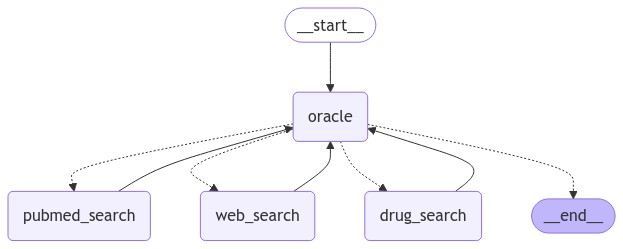

In [42]:
from IPython.display import Image, display

display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))

In [11]:
user_query = "hello"

chat_history = []
for i in range(3):
    user_query = input("Enter your query:\n")
    print(user_query)
    print()
    dicts = {"input": user_query, "chat_history": chat_history}
    response = runnable.invoke(dicts)
    print(response['intermediate_steps'][0])
    out = response['intermediate_steps'][0].tool_input['response']
    chat_history.extend([user_query, out])
    print(f"\n {out} \n")


Paracetamol

=====================out========================
content='0' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 1381, 'total_tokens': 1383, 'completion_time': 0.006223261, 'prompt_time': 0.164130199, 'queue_time': 0.0029926309999999956, 'total_time': 0.17035346}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_7ab5f7e105', 'finish_reason': 'stop', 'logprobs': None} id='run-92539c78-7adf-4c0f-b840-5bd23df5dc7e-0' usage_metadata={'input_tokens': 1381, 'output_tokens': 2, 'total_tokens': 1383}
=====================Args========================


IndexError: list index out of range

In [225]:
response['intermediate_steps'][0].tool_input['response']

" Hello! I'm SolHealth, your trusted health companion. How can I assist you today?"

In [216]:
response

{'input': 'hello',
 'chat_history': [],
 'intermediate_steps': [AgentAction(tool='None', tool_input={'response': " Hello! I'm SolHealth, your trusted guide for all health-related queries. How can I assist you today?", 'research_steps': 'None'}, log=" Hello! I'm SolHealth, your trusted guide for all health-related queries. How can I assist you today?")]}

In [ ]:

def drug_info(links):
    results = []

    for link in links:
        response = requests.get(link)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            
            # Attempt to find the summary container
            summary_container = soup.find('div', class_="monograph_cont")
            summary = summary_container.text.strip() if summary_container else "No summary available."

            # Attempt to find the uses container
            uses_container = soup.find_all('div', class_="pgContent")
            uses = uses_container[1].text.strip() if len(uses_container) > 1 else "No uses information available."

            # Append the result
            result = f"Summary:\n{summary}\n\nUses:\n{uses}"
            results.append(result)

    final_response = "\n\n---\n\n".join(results)
    return final_response


def extract_pubmed_abstract(links):

    results = []
    for link in links:

        response = requests.get(link)

        if response.status_code == 200:
            
            soup = BeautifulSoup(response.text, "html.parser")
            abstact_container = soup.find('div', class_="abstract")
            abstract = abstact_container.text
            results.append(abstract)

    final_response = "\n".join([i for i in results])
    return final_response


In [ ]:
# PubMed Search Tool
@tool('pubmed_search')
def pubmed_search(query: str):
    """
    Searches PubMed for scientific articles related to a given medical query.
    Returns the top articles and links to their abstracts.
    PubMed is a trusted source for peer-reviewed medical research articles.
    """
    handle = Entrez.esearch(db="pubmed", term=query, retmax=1)
    record = Entrez.read(handle)
    handle.close()

    if record["IdList"]:
        ids = record["IdList"]
        article_links = [f'https://pubmed.ncbi.nlm.nih.gov/{id}/' for id in ids]

        # Extract article abstracts (you'll need an actual method for this)
        article = extract_pubmed_abstract(article_links)

        return f"Top PubMed search results for '{query}':\n{article}"
    else:
        return "No articles found."

# Web Search Tool using Google Search
@tool('web_search')
def web_search(query: str):
    """
    Conducts a Google search using a specific medical query to find relevant
    health information or research articles. Returns the top 5 search results 
    with titles, snippets, and links.
    """
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 2
    })
    results = search.get_dict()["organic_results"]

    # Formatting results into readable output
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

# Drug Search Tool on RxList
@tool('drug_search')
def drug_search(query: str):
    """
    Searches RxList for detailed drug information, including uses, side effects, 
    and warnings. RxList is a trusted source for information on prescription 
    and over-the-counter drugs.
    """
    search_url = f"https://www.rxlist.com/search/rxl/{query}"
    response = requests.get(search_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        results_container = soup.find('div', class_="searchresults main")
        
        if results_container:
            items = results_container.find_all('li', limit=1)
            results = [item.find('a') for item in items]
            links = [link['href'] for link in results]

            # Fetch drug information (requires implementation of drug_info method)
            drugs_info = drug_info(links)

            return drugs_info
        else:
            return "No relevant RxList results found."
    else:
        return "Failed to retrieve RxList results."
    

@tool("medical_response")
def medical_response(response: str, research_steps):
    """
    Provides a detailed and reliable answer to the user's medical query.
    
    - `response`: A well-crafted, concise, and medically accurate response to the user's question.
    - `research_steps`: (Optional) Steps taken to gather the information.
    """

    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    
    return response

In [14]:
response

" I'm SolHealth, the Oracle AI. I'm here to assist you with your questions and provide helpful information. Please feel free to ask me anything, and I'll do my best to respond accordingly."